# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [76]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [77]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [78]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [79]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [80]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [81]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [82]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

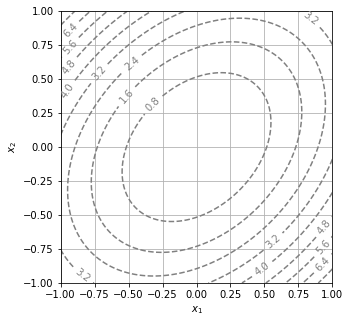

In [83]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [84]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

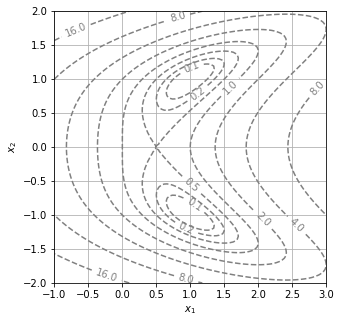

In [85]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [86]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

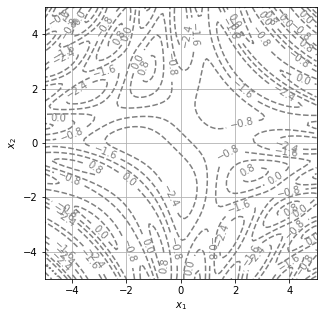

In [87]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [88]:
N = 1000
eps = 10**(-6)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [89]:

        
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    for i in range(N):
        Ji = J_F(x0, y0)
        K = np.linalg.inv(Ji)
        x = -np.dot(K, F(x0, y0))[0] + x0
        y = -np.dot(K, F(x0, y0))[1] + y0
        if (x - x0)**2 + (y - y0)**2 <= eps**2:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
def f4(x, y):
    return np.array([f1(x, y) - 0.8, x - y])

Newton(f4, 0.8, 0.8)

(0.4472135954999579, 0.4472135954999579)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [90]:
def level_curve(f, c, x0, y0, delta = 0.1, eps=eps, N = N):
    tab = np.empty((N, 2))
    tab[0, 0], tab[0, 1] = x0, y0
    for i in range(1, N):
        g = grad(f)(x0, y0)
        ng = np.sqrt(g[0]**2 + g[1]**2)
        a, b = x0 + g[1]/ng, y0 - g[0]/ng
        def F(x, y):
            return np.array([f(x, y) - c, (x0-x)**2 + (y0-y)**2 - delta**2])
        tab[i, 0], tab[i, 1] = Newton(F, a, b, eps, N)
        x0, y0 = Newton(F, a, b, eps, N)

        

        
    A = tab[:, 0]
    B = tab[:, 1]
    plt.plot(A, B, 'g+')
    plt.axis('equal')
    plt.show()
    return tab




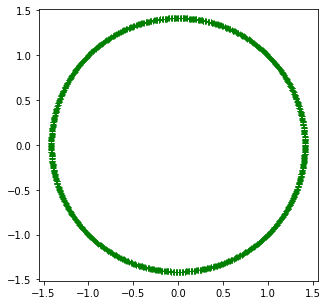

array([[ 1.41421356,  0.        ],
       [ 1.41067803, -0.09993748],
       [ 1.4000891 , -0.19937527],
       ...,
       [ 0.24287358, -1.39320222],
       [ 0.14381371, -1.40688223],
       [ 0.04403477, -1.41352783]])

In [91]:
def f5(x, y):
        return x**2 + y**2

level_curve(f5, 2, np.sqrt(2), 0.)

#avec N = 1000, on fait beaucoup de tours du cercle

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

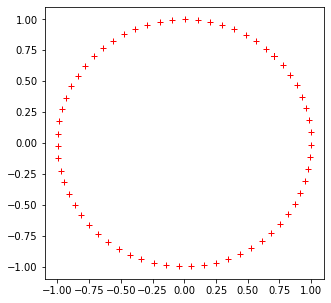

In [92]:
def level_curve2(f, x0, y0,c, delta=0.1, N=N, eps=eps):
    tab=np.full((N,2),[x0,y0]) #pour ne pas avoir un reste de 0
    tab[0][0], tab[0][1]=x0, y0
    x1,y1=x0,y0
    ind=0
    i=0
    while ind==0 and i<N-1:
        i+=1
        g= grad(f)(x1,y1)
        a,b=x1+g[1],y1-g[0]
        def F(x,y):
            return np.array([f(x,y)-c,(x - x1)**2 + (y - y1)**2-delta**2])
        x1,y1=Newton(F,a,b,eps,N)
        if (x1 - x0)**2 + (y1 - y0)**2<(delta-eps)**2: #Nécessaire car la précision de Newton est de eps
            ind=1
        tab[i]=[x1,y1]
    
    

    return tab

def verification(f, x0, y0,c, delta=0.1, N=N, eps=eps):
    Z = level_curve2(f, x0, y0,c, delta=0.1, N=N, eps=eps)
    X = Z[:, 0]
    Y = Z[:, 1]
    plt.plot(X, Y, 'r+')
    plt.show()


verification(f5, np.sqrt(2)/2, np.sqrt(2)/2, 1, delta = 0.1)
    

#on ne fait qu'un tour cette fois

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [93]:
def area_squares(f,c,h,a):
    #avec a entier correctement choisi pour que le carre de côté a centre en 0 contienne l'ensemble
    #1 on modifie a pour que h divise 2a pour un entier
    N=int((2*a/h))+1
    a=(1/2)*(N*h)
    coord =[-a+k*h+h/2 for k in range(N)]
    grille =[[]for i in range(N)]
    for i in range(N):
        for j in range(N):
            grille[i].append([coord[i],coord[j]])
    aire=0
    for abscisse in grille :
        for point in abscisse :
            if f(point[0],point[1])<=c :
                aire+=h**2
    return aire
    

In [94]:
#aire du cercle unité
area_squares(f5, 1, 0.01, 1)

3.1407000000022034

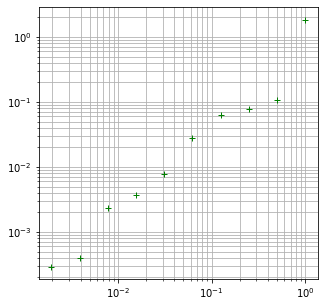

In [95]:
A=np.pi
erreur=[]
L_h=[]
for N in range(10):
    Ah=area_squares(f5,1,1/(2**N),1)
    erreur.append(abs(Ah-A))
    L_h.append(1/(2**N))
plt.plot(L_h,erreur,"g+")
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both")
plt.show()


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [96]:
#Pour la majoration il suffit que l'un des carrés autour soit dedans pour le compter
#Pour la minoration on compte uniquement les carrées dont tout les voisins ont leur centre sous la ligne de niveau sous la ligne de niveau

def area_squares2(f,c,h,a):
    #avec a entier correctement choisi pour que le carre de côté a centre en 0 contienne l'ensemble
    #1 on modifie a pour que h divise 2a pour un entier
    N=int((2*a/h))+1
    a=(1/2)*(N*h)
    coord =[-a+k*h+h/2 for k in range(N)]
    grille =[[]for i in range(N)]
    for i in range(N):
        for j in range(N):
            grille[i].append([coord[i],coord[j]])
    maj_aire=0
    min_aire=0
    for abscisse in grille :
        for point in abscisse :             
                #On teste les carrés autour pour
            indic_min=True
            indic_max=False
            for i in [-1,0,1]:
                for j in [-1,0,1]:
                    x1,x2=(point[0]+i*h,point[1]+j*h)
                    if f(x1,x2)>c: 
                        indic_min=False
                    else :
                        indic_max=True
            if indic_min==True :
                min_aire+=h**2
            if indic_max==True:
                maj_aire+=h**2

    return (min_aire,maj_aire)

In [97]:
#Encadrement du cercle unité
area_squares2(f5,1,0.001,1)

(3.133545000084096, 3.1495370000863314)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

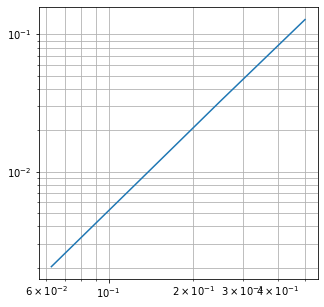

In [98]:
# cercle unité
def airecercle(n, xp, yp, d):
    X, Y = level_curve2(f5, 1., 0., 1., N=n, delta = d)[:,0], level_curve2(f5, 1., 0., 1., N=n, delta = d)[:,1]
    S = 0
    for i in range(n-1):

        a = np.sqrt((xp-X[i])**2 + (yp - Y[i])**2)
        b = np.sqrt((xp - X[i+1])**2 + (yp - Y[i+1])**2)
        sinalpha = ( (X[i+1] - xp)*(Y[i] - yp) - (X[i] - xp)*(Y[i+1] - yp))/(a*b) # on utilise le produit vectoriel
        S = S + b*a*sinalpha/2
    return S

airecercle(100, 0., 0., 0.1)

def convergence_int(n = 10**3): # n suffisamment grand pour faire tout le tour du cercle même avec delta petit 
    deltas = np.array([2**(-i) for i in range(1, 5)])
    ecarts = np.array([np.pi - airecercle(n, 0., 0., d) for d in deltas]) #le point de référence est (0, 0) dans le cercle
    plt.plot(deltas, ecarts)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which = 'both')
    plt.show()

convergence_int()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

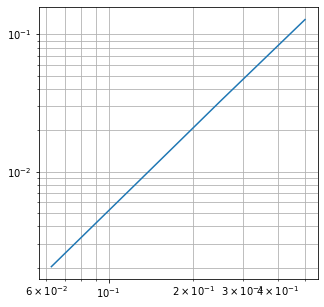

In [99]:


def convergence_ext(n = 10**3): # n suffisamment grand pour faire tout le tour du cercle même avec delta petit 
    deltas = np.array([2**(-i) for i in range(1, 5)])
    ecarts = np.array([np.pi - airecercle(n, 5., 5., d) for d in deltas]) #le point de référence est (5, 5) hors du cercle
    plt.plot(deltas, ecarts)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which = 'both')
    plt.show()

convergence_ext()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

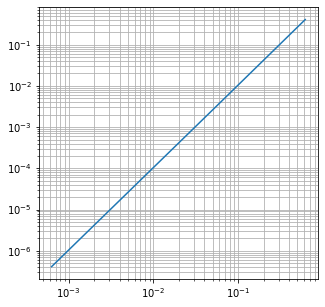

In [100]:
#on considère la réunion du cercle unité et du cercle unité décalé de 3 unités à droite
def frontiere(nb = N): 
    X = np.array([np.cos(2*k*np.pi/nb) for k in range(nb)] + [np.cos(2*k*np.pi/nb) + 3 for k in range(nb)] + [1])[::-1]
    Y = np.array([np.sin(2*k*np.pi/nb) for k in range(nb)] + [np.sin(2*k*np.pi/nb) for k in range(nb)] + [0])[::-1]
    return X, Y
#on veille à avoir le dernier point égal au premier et à parcourir dans le sens horaire

def aire_cercles_disjoints(nb, xp, yp):
    X, Y = frontiere(nb)
    taille = len(X) # 2nb+1
    S = 0
    for i in range(taille-1):

        a = np.sqrt((xp-X[i])**2 + (yp - Y[i])**2)
        b = np.sqrt((xp - X[i+1])**2 + (yp - Y[i+1])**2)
        sinalpha = ( (X[i+1] - xp)*(Y[i] - yp) - (X[i] - xp)*(Y[i+1] - yp))/(a*b) # on utilise le produit vectoriel
        S = S + b*a*sinalpha/2
    return S

aire_cercles_disjoints(1000, 0, 0)

def convergence_disjoint(n = 10**3):
    nbs = [10**i for i in range(1, 5)]
    deltas = np.array([np.sqrt(2 - 2*np.cos(2*np.pi/nb)) for nb in nbs]) #ecart entre deux points cinsecutifs sur le cercle
    ecarts = np.array([2*np.pi - aire_cercles_disjoints(nb, 1.5, 0.) for nb in nbs]) #le point de référence est (1.5, 0) entre les cercles
    plt.plot(deltas, ecarts)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which = 'both')
    plt.show()

convergence_disjoint()

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [101]:
def area_triangles(x, y):
    S = 0
    xp, yp = 0., 0.  # on a vu que ce point peut être choisi quelconque
    for i in range(len(x)-1):
        a = np.sqrt((xp-x[i])**2 + (yp - x[i])**2)
        b = np.sqrt((xp - x[i+1])**2 + (yp - y[i+1])**2)

        sinalpha = ( (x[i+1] - xp)*(y[i] - yp) - (x[i] - xp)*(y[i+1] - yp))/(a*b)
        S = S + b*a*sinalpha/2
    return S


area_triangles(level_curve2(f5, 1., 0., 1.)[:, 0], level_curve2(f5, 1., 0., 1.)[:, 1])

3.136378488532549

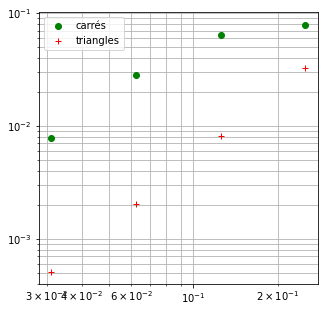

In [102]:
def comparaison():
    pas = [2**(-i) for i in range(2, 6)]
    ecarts_squares = [np.pi - area_squares(f5, 1, d, 2.) for d in pas]
    ecarts_triangles = [np.pi - area_triangles(level_curve2(f5, 1., 0., 1., delta = d)[:, 0], level_curve2(f5, 1., 0., 1., delta = d)[:, 1]) for d in pas]
    plt.plot(pas, ecarts_squares, 'go', label = 'carrés')
    plt.plot(pas, ecarts_triangles, 'r+', label = 'triangles')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which = 'both')
    plt.show()

comparaison()



La méthode des triangles converge plus rapidement.
En revanche elle fait appel à la fonction level_curve (construit une liste de taille N), qui elle même fait appel à la fonction Newton (N itérations): elle est donc beaucoup plus complexe.
